# BSD68 Dataset Denoising using Noise2Void

Il seguente Notebook descrive, passo per passo, l'addestramento e il testing di una Rete Neurale U-Net per la Riduzione del Rumore da immagini tratte dal [Dataset BSD68](https://paperswithcode.com/dataset/bsd).  
La Rete Neurale applica l'Algoritmo Noise2Void, la cui implementazione è resa disponibile dalla libreria [CAREamics](https://careamics.github.io/0.1/), per estrarre immagini pulite senza necessità di alcuna Ground Truth.

Obiettivo dell'attività è comprendere le potenzialità delle Deep Neural Networks nell'ambito del Denoising, confrontare i loro risultati con quelli ottenuti tramite metodi di denoising tradizionali e imparare a conoscere l'Algoritmo N2V.

Il Dataset BSD68 offre un'interessante prospettiva poiché rappresentante un Benchmark di riferimento per attività di ricerca sulla riduzione del rumore. Contiene una varietà di immagini, in bianco e nero, rappresentanti scene naturali, animali, umani e oggetti.  
Le immagini sono state manualmente alterate per contenere del rumore, di intensità differenti. Questo significa che il Dataset mette a disposizione anche le Ground Truth, con cui confrontare i propri risultati.

In questo contesto vogliamo sfruttare l'esistenza di Ground Truths per poter valutare le capacità dell'Algoritmo Noise2Void, con soggetti riconoscibili da ogni tipo di pubblico.


## Download del Dataset

Il Dataset viene scaricato usufruendo del Portfolio reso disponibile dalla libreria CAREamics stessa.  
Contiene più di 3000 immagini con formati e soggetti differenti, rappresentate in formato .TIFF in una particolare codifica di [ImageJ](https://imagej.net/).

Le immagini sono già state suddivise in 4 categorie:
* Dati di Training (3168 immagini), che consentono alla Rete Neurale di apprendere i valori migliori per i suoi parametri.
* Dati di Validation (4 immagini), che consentono di valutare l'andamento dell'addestramento per evitare potenziale overfitting.
* Dati di Testing (68 immagini), che verranno utilizzati per testare il Modello a seguito dell'addestramento.
* Ground Truth dei Dati di Testing (68 immagini), che rappresentano le rispettive immagini pulite dei Dati di Testing, per il confronto.


In [ ]:
import tifffile
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr

sys.path.append('library')

import library.dataset as dataset


In [ ]:

# Downlaod the Dataset
root_path = Path("notebooks/data/bsd68")
dataset.load_bsd68_dataset(root_path)

# The Dataset is already split into Training, Validation, Testing and Grand Truths
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"


Loading BSD68 Dataset
BSD68 Dataset Loaded at notebooks/data/bsd68


## Visualizzazione del Dataset


Visualizziamo alcune immagini del Dataset a scopo illustrativo.  

Si può osservare come ad alcune di queste immagini siano state applicate trasformazioni quali simmetrie e rotazioni, come solitamente accade per l'addestramento tramite U-Net.   
In questo modo la Rete dovrebbe risultare più robusta anche in situazioni diverse da quelle con cui è stata addestrata.

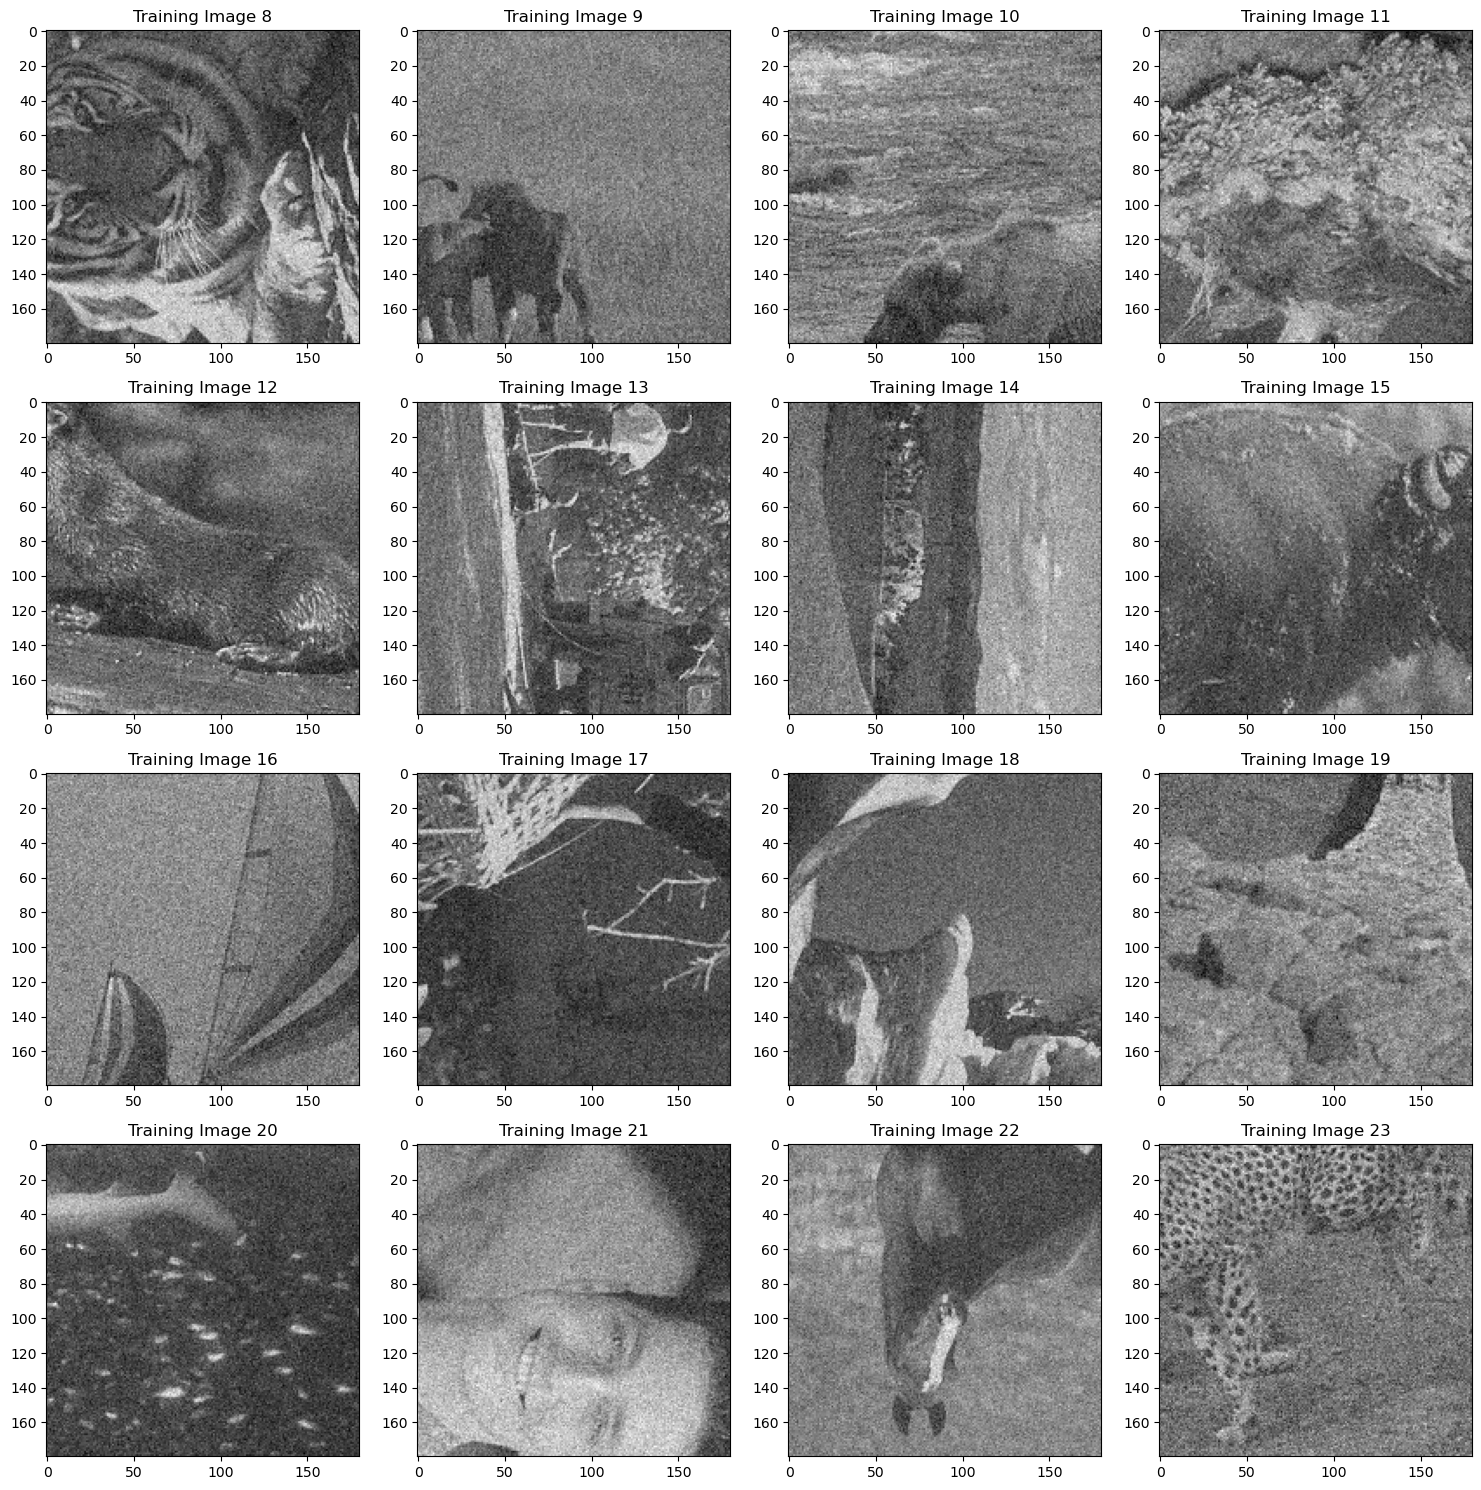

In [ ]:

train_images = tifffile.imread(next(iter(train_path.rglob("*.tiff")))) # 3168 images
val_images = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))
starting_index = 8 #Change this to show different images

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for ax, idx in zip(axes.flat, range(starting_index, starting_index + 16)): #Couples the axes with the indexes
    ax.imshow(train_images[idx], cmap="gray")
    ax.set_title(f"Training Image {idx}")

plt.tight_layout()
plt.show()


## Creazione della configurazione di Training

Prima di procedere all'addestramento della Rete, occorre creare un oggetto di Configurazione dell'addestramento e della Rete che si desidera utilizzare.

I parametri più rilevanti per l'addestramento sono:
* ```batch_size```
* ```num_epochs```

Aggiustare il valore di questi parametri coerentemente alle caratteristiche dell'hardware su cui si intende svolgere l'addestramento.

In [ ]:
config = create_n2v_configuration(
    experiment_name="bsd68_n2v",
    data_type="tiff",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SYX',
                 'batch_size': 64,
                 'data_type': 'tiff',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
     

## Train del modello


L'addestramento del Modello avviene creando un oggetto CAREamist a partire dall'oggetto di Configurazione creato precedentemente.  
Il metodo .train del Modello richiede semplicemente che vengano fornite le immagini di Training e Validation. In questo caso le immagini sono fornite direttamente tramite il percorso di sistema in cui si trovano.

Durante il training è possibile osservare alcuni parametri che ne descrivono l'andamento.


In [ ]:
# Before proceding, make sure your GPU is available to PyTorch or the training will be very slow

careamist = CAREamist(source=config, work_dir="notebooks/models/bsd68")

# train model
print(f"Training starting now...")
careamist.train(train_source=train_path, val_source=val_path)
print("Training ended!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training starting now...


Extracted 28512 patches from input array.
Computed dataset mean: [110.753006], std: [63.603966]
Extracted 36 patches from input array.
/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/c/Users/Filippo Corti/Documents/GitHub/PrincipiEModelliDellaPercezione/notebooks/models/bsd68/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.25it/s]

/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Epoch 9: 100%|██████████| 446/446 [00:43<00:00, 10.15it/s, train_loss_step=0.217, val_loss=0.21, train_loss_epoch=0.209]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 446/446 [00:44<00:00, 10.13it/s, train_loss_step=0.217, val_loss=0.21, train_loss_epoch=0.209]
Training ended!


## Generate Predictions

Terminato l'addestramento, osserviamo il comportamento del Modello chiedendogli di predire le Immagini Pulite per i campioni rumorosi classificati come "Testing".  

Tramite il metodo .predict del Modello utilizziamo l'ultimo Checkpoint disponibile per predirre le 68 immagini del BSD68 Dataset.  

In [ ]:

output_path = "notebooks/predictions/bsd68/predictions.tiff"

prediction = careamist.predict(
    source=test_path,
    axes="YX",
    tile_size=(128, 128),
    tile_overlap=(48, 48),
    batch_size=1,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: |                                                             | 1632/? [00:45<00:00, 35.97it/s]


## Visualize the Predictions

A questo punto non resta che mostrare il risultato delle predizioni del Modello.

Per semplicità vengono mostrate solo n immagini, scelte casualmente dal dataset.  
Vengono inoltre messe a confronto le predizioni ottenute con le Ground Truth disponibili nel Dataset, per consentire una migliore valutazione del lavoro svolto dalla Rete Neurale.

Le immagini sono una buona rappresentazione delle capacità dell'Algoritmo N2V quanto dei suoi limiti empirici.

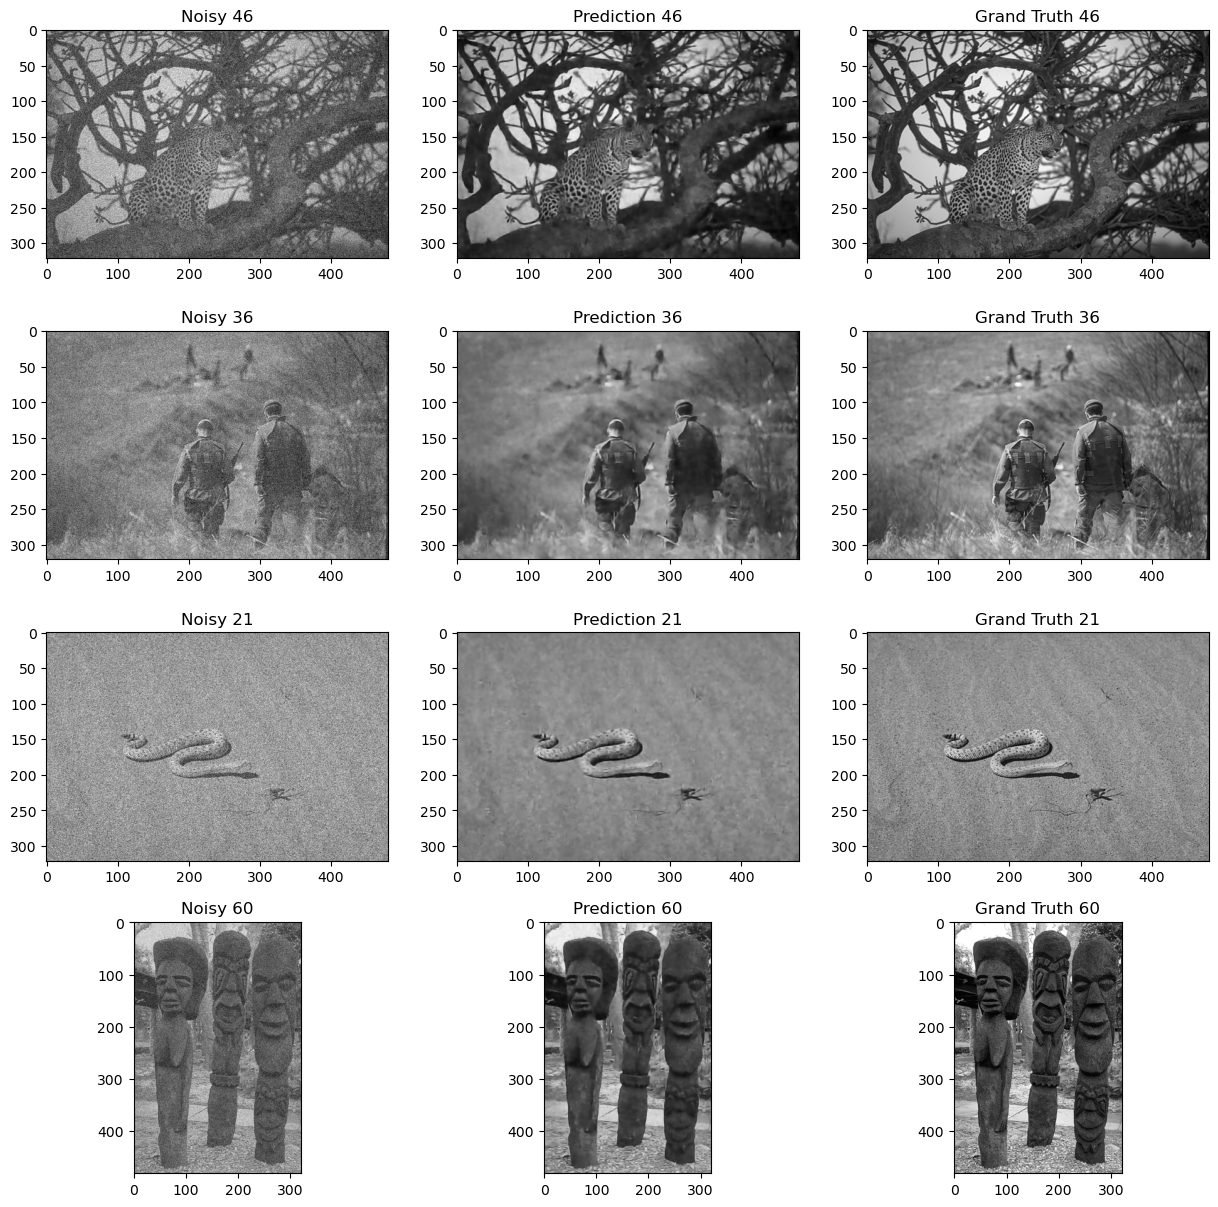

In [ ]:
n = 4

test_images = [tifffile.imread(f) for f in sorted(test_path.glob("*.tiff"))]
ground_truth_images = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

random_indexes = np.random.choice(range(len(test_images)), n)

fig, ax = plt.subplots(4, 3, figsize=(15, 15))
for a, i in zip(range(n), random_indexes):
    ax[a, 0].imshow(test_images[i], cmap="gray")
    ax[a, 0].set_title(f"Noisy {i}")
    ax[a, 1].imshow(prediction[i].squeeze(), cmap="gray")
    ax[a, 1].set_title(f"Prediction {i}")
    ax[a, 2].imshow(ground_truth_images[i], cmap="gray")
    ax[a, 2].set_title(f"Grand Truth {i}")